In [12]:
# Make sure dependencies are installed
!{sys.executable} -m pip install pandas numpy seaborn sklearn matplotlib

In [90]:
# Author: Shane Arcaro and Nicholas DeLello
# Date: 4/26/2022
# Assignment: Final Project

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


In [ ]:


# Read the data
data = pd.read_csv('../data/fetal_health-1.csv')

[1. 2. 3.] [1655  295  176]


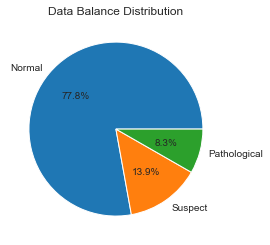

In [9]:
# Three classes: normal, suspect, pathological

# ===============================
#           T A S K # 1
# ===============================

# Get X and Y values from the data setcd cd
X = data.iloc[:, : -1]
Y = data.iloc[:, -1]

# Find and print classification values
values, count = np.unique(Y, return_counts=True)
print(values, count)
# Function used to show percentage on pi chart
def formatPercentage(pct):
    return "{:1.1f}%".format(pct)


# Data is very unbalanced: Normal: 1655, Suspect: 295, Pathological: 176
labels = ['Normal', 'Suspect', 'Pathological']
plt.pie(count, labels=labels, autopct=formatPercentage)
plt.title('Data Balance Distribution')
plt.show()

[1. 2. 3.] [750 750 750]


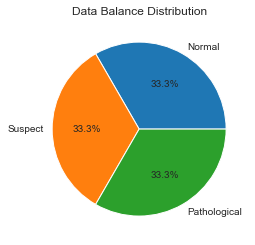

In [17]:
# How to fix imbalanced data? One way is to oversample data
data_majority1 = data[Y == 1]
data_minority2 = data[Y == 2]
data_minority3 = data[Y == 3]

# Number of data points in new sample size
resample_size = 750

# Resample the data, so there's 750 points in each set
data_sample_majority1 = resample(data_majority1, replace=False, n_samples=resample_size)
data_sample_minority2 = resample(data_minority2, replace=True, n_samples=resample_size)
data_sample_minority3 = resample(data_minority3, replace=True, n_samples=resample_size)

# Split the resampled data
data_sample = pd.concat([data_sample_majority1, data_sample_minority2, data_sample_minority3])
x_distribution = data_sample.iloc[:, : -1]
y_distribution = data_sample.iloc[:, -1]
x_distribution_train, x_distribution_test, y_distribution_train, y_distribution_test = train_test_split(x_distribution,
                                                                                                        y_distribution)

# Find and print classification values
values, count = np.unique(y_distribution, return_counts=True)
print(values, count)

# Data was Normal: 1655, Suspect: 295, Pathological: 176, is now evenly split, 750 for each
labels = ['Normal', 'Suspect', 'Pathological']
plt.pie(count, labels=labels, autopct=formatPercentage)
plt.title('Data Balance Distribution')
plt.show()

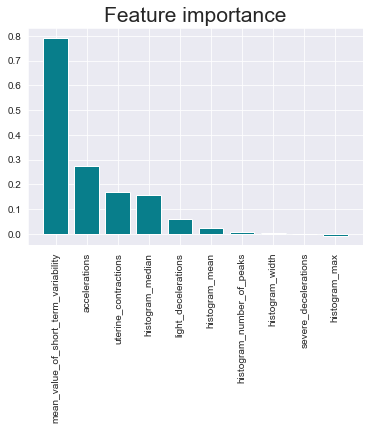

mean_value_of_short_term_variability	P-value: 0.2884	Not 95% confident	Not 90% confident
accelerations	P-value: 0.0000	95% confident	90% confident
uterine_contractions	P-value: 0.0000	95% confident	90% confident
histogram_median	P-value: 0.0000	95% confident	90% confident
light_decelerations	P-value: 0.0000	95% confident	90% confident
histogram_mean	P-value: 0.0000	95% confident	90% confident
histogram_number_of_peaks	P-value: 0.7504	Not 95% confident	Not 90% confident
histogram_width	P-value: 0.2589	Not 95% confident	Not 90% confident
severe_decelerations	P-value: 0.0000	95% confident	90% confident
histogram_max	P-value: 0.0039	95% confident	90% confident


In [85]:

# ===============================
#           T A S K # 2
# ===============================

# Get the P-values for each feature
_p_values = f_regression(x_distribution_train, y_distribution_train)[1]
columns = x_distribution_train.columns
p_values = {columns[i]: _p_values[i] for i in range(len(columns))}

# Get feature importance using Random Forest Regression
model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000, warm_start=True).fit(x_distribution_train, y_distribution_train)
importance = pd.DataFrame(data={
    'Attribute': x_distribution_train.columns,
    'Importance': model.coef_[0]
})
importance = importance.sort_values(by='Importance', ascending=False)[:10]

plt.bar(x=importance['Attribute'], height=importance['Importance'], color='#087E8B')
plt.title('Feature importance', size=21)
plt.xticks(rotation='vertical')
plt.show()

for _, entry in importance.iterrows():
    name = entry["Attribute"]
    p_value = p_values[name]
    print(name, "P-value: {:0.4f}".format(p_value), "95% confident" if p_value < 0.05 else "Not 95% confident", "90% confident" if p_value < 0.1 else "Not 90% confident", sep="\t")

In [154]:

# ===============================
#           T A S K # 3
# ===============================

# This is a multiclass problem that can be treated as regression
# Just need 2 different models to classify the features into the three fetal health states
# Using Statify classifier and RandomForest classifier

# Create stratify classifier
x_stratify_train, x_stratify_test, y_stratify_train, y_stratify_test = train_test_split(x_distribution, y_distribution,
                                                                                        test_size=0.3,
                                                                                        stratify=y_distribution)
model_stratify = SGDClassifier().fit(x_stratify_train, y_stratify_train)
y_prediction_stratify = model_stratify.predict(x_stratify_test)
model_proba = CalibratedClassifierCV(model_stratify, cv="prefit").fit(x_stratify_train, y_stratify_train)
y_prediction_stratify_prob = model_proba.predict_proba(x_stratify_test)

# Create Random Forest classifier
model_stratify_randomforest = RandomForestClassifier().fit(x_stratify_train, y_stratify_train)
y_prediction_randomforest = model_stratify_randomforest.predict(x_stratify_test)
model_proba = CalibratedClassifierCV(model_stratify_randomforest, cv="prefit").fit(x_stratify_train, y_stratify_train)
y_prediction_randomforest_prob = model_proba.predict_proba(x_stratify_test)

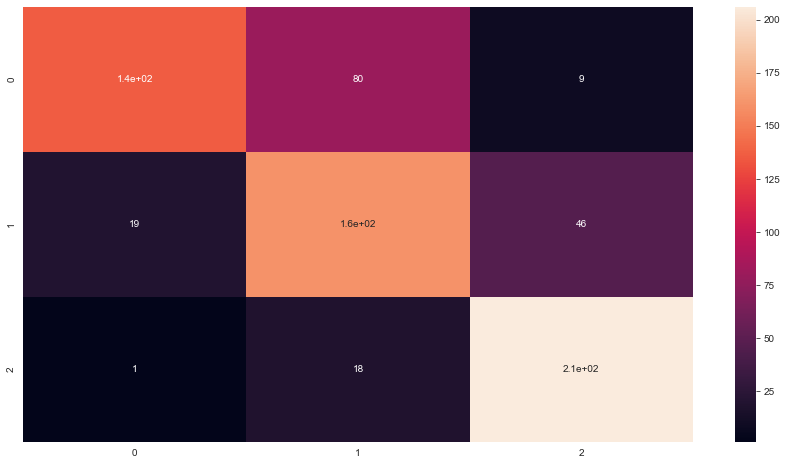

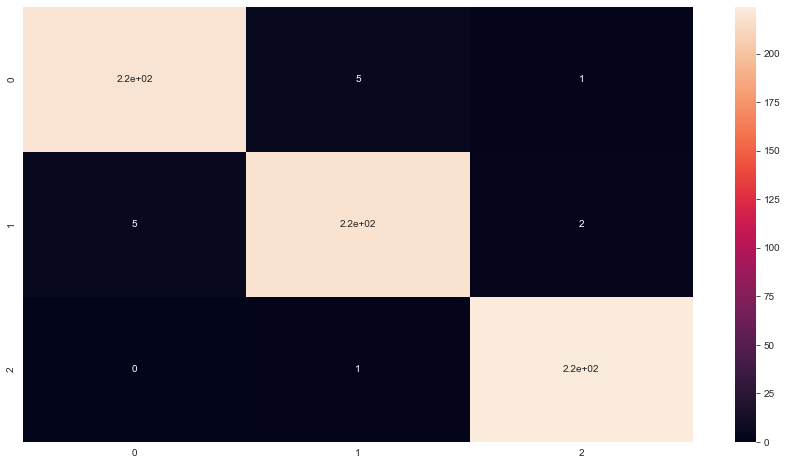

In [158]:

# ===============================
#           T A S K # 4
# ===============================

confusionmatrix = confusion_matrix(y_stratify_test, y_prediction_stratify)
plt.figure(figsize=(15, 8))
sns.heatmap(confusionmatrix, annot=True)
plt.show()

confusionmatrix_forest = confusion_matrix(y_stratify_test, y_prediction_randomforest)
plt.figure(figsize=(15, 8))
sns.heatmap(confusionmatrix_forest, annot=True)
plt.show()

In [159]:
# ===============================
#           T A S K # 5
# ===============================

# Stratify scores
print("Stratify\n---------------------")
print("Area Under ROC:      ", roc_auc_score(y_stratify_test, y_prediction_stratify_prob, multi_class="ovo"))
print("F1 Score:            ", f1_score(y_stratify_test, y_prediction_stratify, average="weighted"))
precisions, recalls, _ = precision_recall_curve(y_stratify_test, y_prediction_stratify, pos_label=1)
print("Area Under Precision for {}:".format(labels[0]), auc(recalls, precisions))
precisions, recalls, _ = precision_recall_curve(y_stratify_test, y_prediction_stratify, pos_label=2)
print("Area Under Precision for {}:".format(labels[1]), auc(recalls, precisions))
precisions, recalls, _ = precision_recall_curve(y_stratify_test, y_prediction_stratify, pos_label=3)
print("Area Under Precision for {}:".format(labels[2]), auc(recalls, precisions))

# Random Forest scores
print("\nRandom Forest\n---------------------")
print("Area Under ROC:      ", roc_auc_score(y_stratify_test, y_prediction_randomforest_prob, multi_class="ovo"))
print("F1 Score:            ", f1_score(y_stratify_test, y_prediction_randomforest, average="weighted"))
precisions, recalls, _ = precision_recall_curve(y_stratify_test, y_prediction_randomforest, pos_label=1)
print("Area Under Precision for {}:".format(labels[0]), auc(recalls, precisions))
precisions, recalls, _ = precision_recall_curve(y_stratify_test, y_prediction_randomforest, pos_label=2)
print("Area Under Precision for {}:".format(labels[1]), auc(recalls, precisions))
precisions, recalls, _ = precision_recall_curve(y_stratify_test, y_prediction_randomforest, pos_label=3)
print("Area Under Precision for {}:".format(labels[2]), auc(recalls, precisions))

Stratify
---------------------
Area Under ROC:       0.9129711934156378
F1 Score:             0.7413910888621478
Area Under Precision for Normal: 0.20987280284071194
Area Under Precision for Suspect: 0.35486225844474467
Area Under Precision for Pathological: 0.8696236745681966

Random Forest
---------------------
Area Under ROC:       0.9976395061728396
F1 Score:             0.9792327755549862
Area Under Precision for Normal: 0.17112550236435486
Area Under Precision for Suspect: 0.2541899565838537
Area Under Precision for Pathological: 0.9922784957124702


<AxesSubplot:xlabel='x', ylabel='y'>

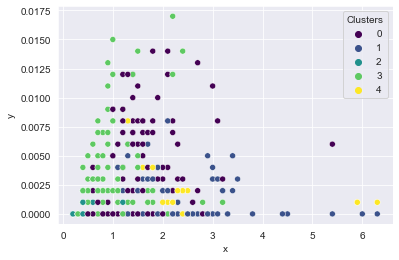

In [128]:
from pandas import Series

# ===============================
#           T A S K # 6
# ===============================
y_stratify_test: Series
km = KMeans(5).fit(x_stratify_test)
df = pd.DataFrame(data={
    # These two attributes were the most significant in part two, so why not pick them for clustering?
    # The assignment doesn't really say how to cluster it, so I picked arbitrarily.
    "x": x_stratify_test["mean_value_of_short_term_variability"],
    "y": x_stratify_test["accelerations"],
    "Clusters": km.labels_
})
sns.scatterplot(x="x", y="y", data=df, hue="Clusters", palette="viridis")

<AxesSubplot:xlabel='x', ylabel='y'>

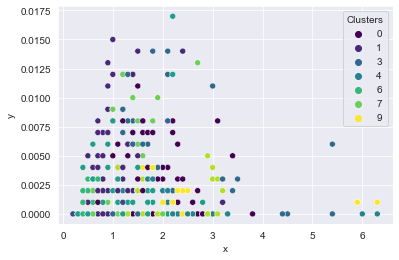

In [129]:
km = KMeans(10).fit(x_stratify_test)
df["Clusters"] = km.labels_
sns.scatterplot(x="x", y="y", data=df, hue="Clusters", palette="viridis")

<AxesSubplot:xlabel='x', ylabel='y'>

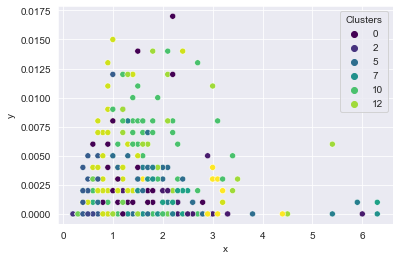

In [130]:
km = KMeans(15).fit(x_stratify_test)
df["Clusters"] = km.labels_
sns.scatterplot(x="x", y="y", data=df, hue="Clusters", palette="viridis")
